In [25]:
import keras
from keras.layers import Dense, Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation, Conv2D
from keras.models import Model, Sequential
from keras.datasets import cifar10
import numpy as np
import random
from keras.layers import Conv2D, Flatten, Dropout
from keras.optimizers import Adam

# Generador de la imagen.

In [26]:
def generador_de_imagenes():

    generador = Sequential()

    generador.add(Dense(256*4*4, input_shape = (100,)))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU())
    generador.add(Reshape((4,4,256)))

    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))


    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))

    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))

    generador.add(Conv2D(3,kernel_size=3, padding = "same", activation='tanh'))

    return(generador)

modelo_generador = generador_de_imagenes()

modelo_generador.summary()


Model: "sequential_3"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 8, 8, 128)         295040    
 Transpose)                                                      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_10 (Conv2  (None, 16, 16, 128)       147584    
 DTranspose)                                                     
          

# Cargando las imágenes

In [27]:
def cargar_imagenes():
    (Xtrain, Ytrain), (_, _) = cifar10.load_data()

    # Nos quedamos con los perros
    indice = np.where(Ytrain == 0)
    indice = indice[0]
    Xtrain = Xtrain[indice, :,:,:]

    # Normalizamos los datos
    X = Xtrain.astype('float32')
    X = (X - 127.5) / 127.5

    return X

print(cargar_imagenes().shape)

(5000, 32, 32, 3)


# Generadores

1/1 [==============================] - 0s 182ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


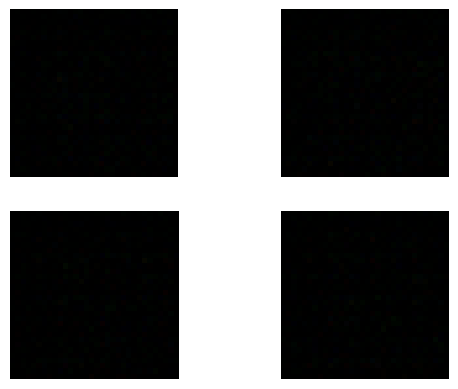

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Definir datos de entrada
def generar_datos_entrada(n_muestras):
  X = np.random.randn(100 * n_muestras)
  X = X.reshape(n_muestras, 100)
  return X

def crear_datos_fake(modelo_generador, n_muestras):
  input = generar_datos_entrada(n_muestras)
  X = modelo_generador.predict(input)
  y = np.zeros((n_muestras, 1))
  return X,y

numero_muestras = 4
X,_ = crear_datos_fake(modelo_generador, numero_muestras)

# Visualizamos resultados
for i in range(numero_muestras):
    plt.subplot(2, 2, 1 + i)
    plt.axis('off')
    plt.imshow(X[i])


# Discriminador de las imágenes

In [29]:
def discriminador_de_imagenes():

    discriminador = Sequential()
    discriminador.add(Conv2D(64, kernel_size=3, padding = "same", input_shape = (32,32,3)))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(256, kernel_size=3, strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Flatten())
    discriminador.add(Dropout(0.4))
    discriminador.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002 ,beta_1=0.5)
    discriminador.compile(loss='binary_crossentropy', optimizer= opt , metrics = ['accuracy'])

    return(discriminador)

modelo_discriminador = discriminador_de_imagenes()
modelo_discriminador.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 256)        

# Cargando los datos reales

In [30]:
def cargar_datos_reales(dataset, n_muestras):
    ix = np.random.randint(0, dataset.shape[0], n_muestras)
    X = dataset[ix]
    y = np.ones((n_muestras, 1))
    return X,y

def cargar_datos_fake(n_muestras):
  X = np.random.rand(32 * 32 * 3 * n_muestras)
  X = -1 + X * 2
  X = X.reshape((n_muestras, 32,32,3))
  y = np.zeros((n_muestras, 1))
  return X,y

# Entrenando el discriminador

In [31]:
def entrenar_discriminador(modelo, dataset, n_iteraciones=20, batch = 128):
    medio_batch = int(batch/2)

    for i in range(n_iteraciones):
        X_real, y_real = cargar_datos_reales(dataset, medio_batch)
        _, acc_real = modelo.train_on_batch(X_real, y_real)

        X_fake, y_fake = cargar_datos_fake(medio_batch)
        _, acc_fake = modelo.train_on_batch(X_fake, y_fake)

        print(str(i+1) + ' Real:' + str(acc_real*100) + ', Fake:' + str(acc_fake*100))


In [32]:
dataset = cargar_imagenes()
entrenar_discriminador(modelo_discriminador, dataset)

1 Real:32.8125, Fake:0.0
2 Real:100.0, Fake:3.125
3 Real:93.75, Fake:76.5625
4 Real:95.3125, Fake:100.0
5 Real:90.625, Fake:100.0
6 Real:100.0, Fake:100.0
7 Real:98.4375, Fake:100.0
8 Real:100.0, Fake:100.0
9 Real:98.4375, Fake:100.0
10 Real:100.0, Fake:100.0
11 Real:100.0, Fake:100.0
12 Real:100.0, Fake:100.0
13 Real:100.0, Fake:100.0
14 Real:100.0, Fake:100.0
15 Real:100.0, Fake:100.0
16 Real:100.0, Fake:100.0
17 Real:100.0, Fake:100.0
18 Real:100.0, Fake:100.0
19 Real:100.0, Fake:100.0
20 Real:100.0, Fake:100.0


# Creando el GAN

In [33]:
def crear_gan(discriminador, generador):
    discriminador.trainable=False
    gan = Sequential()
    gan.add(generador)
    gan.add(discriminador)

    opt = Adam(lr=0.0002,beta_1=0.5) 
    gan.compile(loss = "binary_crossentropy", optimizer = opt)

    return gan

gan = crear_gan(modelo_discriminador,modelo_generador)
gan.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 32, 32, 3)         1007363   
                                                                 
 sequential_4 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1529860 (5.84 MB)
Trainable params: 1007363 (3.84 MB)
Non-trainable params: 522497 (1.99 MB)
_________________________________________________________________


# Funciones de evaluación del modelo y generación de imágenes.

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

def mostrar_imagenes_generadas(datos_fake, epoch):

  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")

  # Hacemos que los datos vayan de 0 a 1
  datos_fake = (datos_fake + 1) / 2.0

  for i in range(10):
    plt.imshow(datos_fake[i])
    plt.axis('off')
    nombre = str(epoch) + '_imagen_generada_' + str(i) + '.png'
    plt.savefig(nombre, bbox_inches='tight')
    plt.close()


In [35]:
def evaluar_y_guardar(modelo_generador, epoch, medio_dataset):
    
  # Guardamos el modelo
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  nombre = str(epoch) + '_' + str(now)+"_modelo_generador_" + '.h5'
  modelo_generador.save(nombre)

  # Generamos nuevos datos
  X_real,Y_real = cargar_datos_reales(dataset, medio_dataset)
  X_fake, Y_fake =  crear_datos_fake(modelo_generador,medio_dataset)

  # Evaluamos el modelo
  _, acc_real = modelo_discriminador.evaluate(X_real, Y_real)
  _, acc_fake = modelo_discriminador.evaluate(X_fake, Y_fake)

  print('Acc Real:' + str(acc_real*100) + '% Acc Fake:' + str(acc_fake*100)+'%')


In [36]:
def entrenamiento(datos, modelo_generador, modelo_discriminador, epochs, n_batch, inicio = 0):
    dimension_batch = int(datos.shape[0]/n_batch)  
    medio_dataset = int(n_batch/2)

    # Iteramos para todos los epochs
    for epoch in range(inicio, inicio + epochs):
        # Iteramos para todos los batches
        for batch in range(n_batch):

            # Cargamos datos reales
            X_real,Y_real = cargar_datos_reales(dataset, medio_dataset)


            # Enrenamos discriminador con datos reales
            coste_discriminador_real, _ = modelo_discriminador.train_on_batch(X_real, Y_real)
            X_fake, Y_fake =  crear_datos_fake(modelo_generador,medio_dataset)

            coste_discriminador_fake, _ = modelo_discriminador.train_on_batch(X_fake, Y_fake)

            # Generamos datos de entadas de la GAN
            X_gan = generar_datos_entrada(medio_dataset)
            Y_gan = np.ones((medio_dataset, 1))

            # Entrenamos la GAN con datos falsos
            coste_gan = gan.train_on_batch(X_gan, Y_gan)

            # Cada 10 Epochs mostramos resultados y el coste
            if (epoch+1) % 10 == 0:
                evaluar_y_guardar(modelo_generador,epoch = epoch, medio_dataset= medio_dataset)
                mostrar_imagenes_generadas(X_fake, epoch = epoch)


In [38]:
entrenamiento(dataset, modelo_generador, modelo_discriminador, epochs = 40, n_batch=128, inicio = 0)

2/2 [==============================] - 0s 81ms/step


KeyboardInterrupt: 

In [ ]:
X_fake, _ = crear_datos_fake(n_muestras=49, modelo_generador=modelo_generador)
X_fake = (X_fake+1)/2

for i in range(49):
  plt.subplot(7,7,i+1)
  plt.axis('off')
  plt.imshow(X_fake[i])